In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import csv
import os
import sys
import numpy as np
import collections
import scipy.io
import time

# CNN bits
import theano
import theano.tensor as T
import lasagne
from lasagne import layers

# for evaluation
sys.path.append(os.path.expanduser('~/projects/engaged_hackathon/'))
from engaged.features import evaluation
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

# https://groups.google.com/forum/#!topic/lasagne-users/t_rMTLAtpZo
theano.config.profile = True
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from sklearn import metrics

Using gpu device 0: GeForce GTX 770 (CNMeM is disabled)


In [11]:
# load in the data
base_path = '/home/michael/projects/engaged_hackathon_data/urban_8k/'
split = 1
loadpath = base_path + 'splits/split' + str(split) + '.mat'
dataset = scipy.io.loadmat(loadpath)

num_classes = np.unique(dataset['train_y']).shape[0]
print "There are %d classes " % num_classes
print np.unique(dataset['train_y'])
dataset['train_y'] = dataset['train_y'].ravel().astype(np.int32)
dataset['test_y'] = dataset['test_y'].ravel().astype(np.int32)
dataset['val_y'] = dataset['val_y'].ravel().astype(np.int32)

if False:
    for data_type in ['train_', 'test_', 'val_']:
        num = data[data_type + 'X'].shape[0]
        to_use = np.random.choice(num, 100, replace=False)
        dataset[data_type + 'X'] = dataset[data_type + 'X'][to_use, :]
        dataset[data_type + 'y'] = dataset[data_type + 'y'][to_use]

There are 10 classes 
[0 1 2 3 4 5 6 7 8 9]


In [3]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]


In [4]:
import cPickle as pickle
network, predict_fn = pickle.load(open('./best_model_0.60.pkl'))

In [5]:
# After training, we compute and print the test error:
all_preds = []
all_gt = []
minibatch_size = 8

for batch in iterate_minibatches(data['test_X'], data['test_y'], int(minibatch_size), shuffle=False):
    inputs, targets = batch
    preds = predict_fn(inputs)
    all_preds.append(preds)
    all_gt.append(targets)

all_preds = np.vstack(all_preds)
all_gt = np.hstack(all_gt)

In [6]:
print metrics.accuracy_score(np.argmax(all_preds, axis=1), all_gt)

0.582568807339


In [8]:
import pandas as pd

base_path = '/home/michael/projects/engaged_hackathon_data/urban_8k/'
meta_path = base_path + 'UrbanSound8K/metadata/UrbanSound8K.csv'

unique_labels = [''] * 10

# data = 
data = pd.read_csv(meta_path)
for row in data.iterrows():
    unique_labels[row[1]['classID']] = row[1]['class']
# print data
print unique_labels 

['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']


/home/michael/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


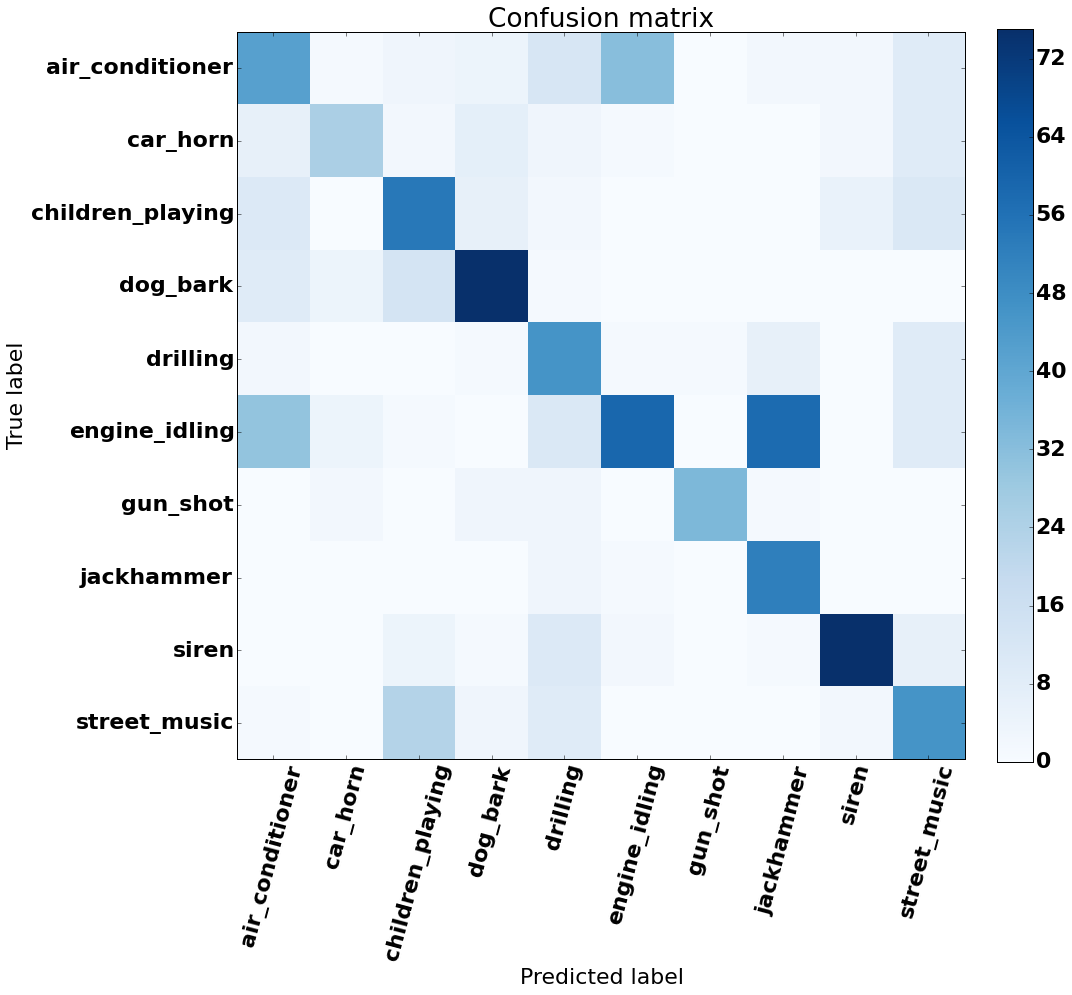

In [9]:
cm = metrics.confusion_matrix(np.argmax(all_preds, axis=1), all_gt)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(unique_labels))
    plt.xticks(tick_marks, unique_labels, rotation=75)

    plt.yticks(tick_marks, unique_labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 22}

plt.rc('font', **font)
plt.figure(figsize=(15, 15))
plot_confusion_matrix(cm)

In [28]:
from itertools import product

def occlusion_heatmap(net, x, target, square_length=7):
    """An occlusion test that checks an image for its critical parts.
    In this function, a square part of the image is occluded (i.e. set
    to 0) and then the net is tested for its propensity to predict the
    correct label. One should expect that this propensity shrinks of
    critical parts of the image are occluded. If not, this indicates
    overfitting.
    Depending on the depth of the net and the size of the image, this
    function may take awhile to finish, since one prediction for each
    pixel of the image is made.
    Currently, all color channels are occluded at the same time. Also,
    this does not really work if images are randomly distorted by the
    batch iterator.
    See paper: Zeiler, Fergus 2013
    Parameters
    ----------
    net : NeuralNet instance
      The neural net to test.
    x : np.array
      The input data, should be of shape (1, c, x, y). Only makes
      sense with image data.
    target : int
      The true value of the image. If the net makes several
      predictions, say 10 classes, this indicates which one to look
      at.
    square_length : int (default=7)
      The length of the side of the square that occludes the image.
      Must be an odd number.
    Results
    -------
    heat_array : np.array (with same size as image)
      An 2D np.array that at each point (i, j) contains the predicted
      probability of the correct class if the image is occluded by a
      square with center (i, j).
    """
    if (x.ndim != 4) or x.shape[0] != 1:
        raise ValueError("This function requires the input data to be of "
                         "shape (1, c, x, y), instead got {}".format(x.shape))
    if square_length % 2 == 0:
        raise ValueError("Square length has to be an odd number, instead "
                         "got {}.".format(square_length))

    # num_classes = net.layers_[-1].num_units
    img = x[0].copy()
    shape = x.shape

    heat_array = np.zeros(shape[2:])
    pad = square_length // 2 + 1
    x_occluded = np.zeros((shape[2], shape[3], shape[2], shape[3]),
                          dtype=img.dtype)

    # generate occluded images
    for i, j in product(*map(range, shape[2:])):
        x_padded = np.pad(img, ((0, 0), (pad, pad), (pad, pad)), 'constant')
        x_padded[:, i:i + square_length, j:j + square_length] = 0.
        x_occluded[i, j, :, :] = x_padded[:, pad:-pad, pad:-pad]

    # make batch predictions for each occluded image
    probs = np.zeros((shape[2], shape[3], num_classes))
    for i in range(shape[3]):
        y_proba = predict_fn(x_occluded[:, i:i + 1, :, :])
        probs[:, i:i + 1, :] = y_proba.reshape(shape[2], 1, num_classes)

    # from predicted probabilities, pick only those of target class
    for i, j in product(*map(range, shape[2:])):
        heat_array[i, j] = probs[i, j, target]
    return heat_array


In [61]:
heatmaps = []
print dataset['test_X'].shape[0]
for num in range(dataset['test_X'].shape[0]):
    X = dataset['test_X'][num, ...].reshape((1, 1, 129, 199))
    y = dataset['test_y'][num]
    heatmaps.append(occlusion_heatmap(network, X, y, square_length=51))
    print num,

873
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74

KeyboardInterrupt: 

 75


<matplotlib.colorbar.Colorbar instance at 0x7fec0436fd88>

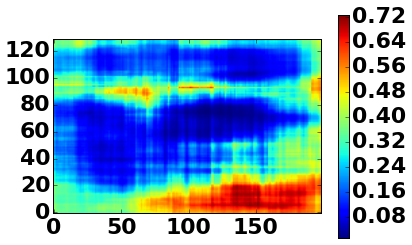

In [62]:
# print heatmap.shape
print len(heatmaps)
plt.imshow(heatmaps[10])
plt.gca().invert_yaxis()
plt.colorbar()

(129, 199)


<matplotlib.colorbar.Colorbar instance at 0x7fec0494b170>

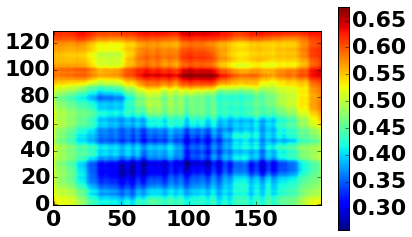

In [63]:
# plt.imshow(X[0, 0, ...])
# plt.gca().invert_yaxis()
avg_heatmap = np.dstack(heatmaps).mean(2)
print avg_heatmap.shape
plt.imshow(avg_heatmap)
plt.gca().invert_yaxis()
plt.colorbar()

In [54]:
print data.iterrows().next(num)

TypeError: expected 0 arguments, got 1